In [1]:
# !pip install sciann==0.5.4.0
# !pip install tensorflow==2.2.0
# #!pip install keras==2.3.1 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel, PDE
from sciann.utils import *
import scipy.io 
import time
import random

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)] 



In [3]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [4]:
# Model specifications
v0 = 2.  # Velocity at the origin of the model
vergrad = 0.5  # Vertical gradient
horgrad = 0.  # Horizontal gradient

zmin = 0.; zmax = 6.; deltaz = 0.05
xmin = 0.; xmax = 6.; deltax = 0.05

# Point-source location
num_points = 8  # Number of source points
radius = 2  # Radius of the circle

# Creating grid
z = np.arange(zmin, zmax + deltaz, deltaz)
nz = z.size

x = np.arange(xmin, xmax + deltax, deltax)
nx = x.size

# Gradient layer
Z, X = np.meshgrid(z, x, indexing='ij')

# Create circular velocity model
center_x = (xmax - xmin) / 2
center_z = (zmax - zmin) / 2
dist_from_center = np.sqrt((X - center_x)**2 + (Z - center_z)**2)
velmodel = v0 + vergrad * (dist_from_center - radius)

# Modify velocity model
velmodel[dist_from_center <= radius] = 3  # Inside the circle
velmodel[dist_from_center > radius] = 5   # Outside the circle

# Create mesh of sources distributed along the boundary of the circle
theta = np.linspace(0, 2*np.pi, num_points, endpoint=False)
sx = center_x + radius * np.cos(theta)
sz = center_z + radius * np.sin(theta)

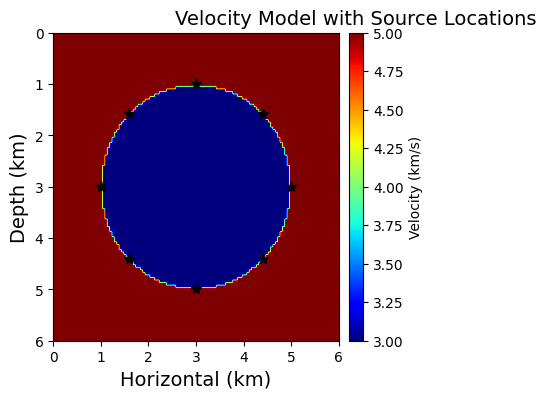

In [5]:
# Plot the velocity model with source locations
plt.style.use('default')
plt.figure(figsize=(4, 4))  # Adjust the figure size as needed

ax = plt.gca()
im = ax.imshow(velmodel, extent=[xmin, xmax, zmax, zmin], aspect='auto', cmap="jet")

# Plot source locations
for i in range(len(sx)):
    ax.plot(sx[i], sz[i], 'k*', markersize=8)

plt.xlabel('Horizontal (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Velocity (km/s)', size=10)
cbar.ax.tick_params(labelsize=10)

plt.title('Velocity Model with Source Locations', fontsize=14)

plt.show()

In [6]:
# Preparing necessary arrays for the sources

X_star, Z_star, SX_star, SZ_star, T0_star, px0_star, pz0_star, tau_star, V_star = [[] for i in range(9)]


for ns, (szi, sxi) in enumerate(zip(sz, sx)):

    vs = v0 + vergrad*szi + + horgrad*sxi # Velocity at source point
    velmodel = vs + vergrad*(Z-szi) + horgrad*(X-sxi);

    T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sxi)**2 + (Z-szi)**2))/np.sqrt(vergrad**2 + horgrad**2)

    T0 = np.sqrt((Z-szi)**2 + (X-sxi)**2)/vs; 
    px0 = np.divide(X-sxi, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
    pz0 = np.divide(Z-szi, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

    tau_data = np.divide(T_data, T0, out=np.ones_like(T0), where=T0!=0)

    X_star.append(X.reshape(-1, 1))
    Z_star.append(Z.reshape(-1, 1))
    SX_star.append(np.ones_like(X.reshape(-1, 1)).reshape(-1,1)*sxi)
    SZ_star.append(np.ones_like(X.reshape(-1, 1)).reshape(-1,1)*szi)
    T0_star.append(T0.reshape(-1,1))
    px0_star.append(px0.reshape(-1,1))
    pz0_star.append(pz0.reshape(-1,1))
    tau_star.append(tau_data.reshape(-1,1))
    V_star.append(velmodel.reshape(-1,1))


X_star = np.concatenate(X_star, axis=0)
Z_star = np.concatenate(Z_star, axis=0)
SX_star = np.concatenate(SX_star, axis=0)
SZ_star = np.concatenate(SZ_star, axis=0)
tau_star = np.concatenate(tau_star, axis=0)
T0_star = np.concatenate(T0_star, axis=0)
px0_star = np.concatenate(px0_star, axis=0)
pz0_star = np.concatenate(pz0_star, axis=0)
V_star = np.concatenate(V_star, axis=0)

In [7]:
K.clear_session() 

layers = [20]*10

xt = Variable("xt",dtype='float64')
zt = Variable("zt",dtype='float64')
vt = Variable("vt",dtype='float64')
px0t = Variable("px0t",dtype='float64')
pz0t = Variable("pz0t",dtype='float64')
T0t = Variable("T0t",dtype='float64')
sxt = Variable("sxt",dtype='float64')
szt = Variable("szt",dtype='float64')

tau = Functional("tau", [xt, zt, sxt, szt], layers, 'l-atan')

L = (T0t*diff(tau, xt) + tau*px0t)**2 + (T0t*diff(tau, zt) + tau*pz0t)**2 - 1.0/vt**2


targets = [tau, PDE(20*L), (1-sign(tau))*abs(tau)]
target_vals = [tau_star, 'zeros', 'zeros']

model = SciModel(
    [xt, zt, pz0t, px0t, T0t, sxt, szt, vt], 
    targets
)

In [8]:
start_time = time.time()
hist = model.train(
    [X_star, Z_star, pz0_star, px0_star, T0_star, SX_star, SZ_star, V_star],
    target_vals, 
    batch_size=2000,
    epochs=65,
    verbose=0,
    learning_rate=0.0005
    )
elapsed = time.time() - start_time
print('Training time: %.2f seconds' %(elapsed))


Total samples: 117128 
Batch size: 2000 
Total batches: 59 

Training time: 507.30 seconds


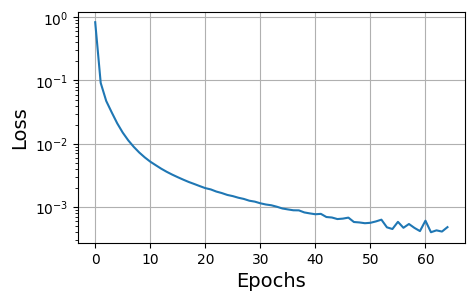

In [9]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(hist.history['loss'])

ax.set_xlabel('Epochs',fontsize=14)

plt.xticks(fontsize=10)
#ax.xaxis.set_major_locator(plt.MultipleLocator(500))

ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=10);
plt.grid()

In [10]:
# Selecting a source position for testing

np.random.seed(123)
sz = np.round(np.random.uniform(zmin,zmax),decimals=1)
sx = np.round(np.random.uniform(xmin,xmax),decimals=1)

print(sx)
print(sz)

1.7
4.2


In [11]:
vel = velmodel[int(round(sz/deltaz)),int(round(sx/deltax))] # Velocity at the source location

T0 = np.sqrt((Z-sz)**2 + (X-sx)**2)/vel; 

px0 = np.divide(X-sx, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-sz, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)

In [12]:
start_time = time.time()
tau_pred = tau.eval(model, [X, Z, px0, pz0, T0, np.ones_like(X)*sx, np.ones_like(X)*sz, velmodel])
elapsed = time.time() - start_time
print('Evaluation time: %.2f seconds' %(elapsed))

tau_pred = tau_pred.reshape(Z.shape)
T_pred = tau_pred*T0

Evaluation time: 0.70 seconds


In [13]:
vs = v0 + vergrad*sz + horgrad*sx
T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sx)**2 + (Z-sz)**2))/np.sqrt(vergrad**2 + horgrad**2)

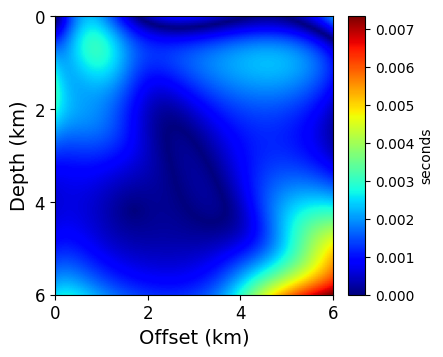

In [14]:
# Plot the computed tau

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_pred-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

#cbar.mappable.set_clim(0,0.0006)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("./figs/vofxz_surrogate/pinnerror.pdf", format='pdf', bbox_inches="tight")

In [15]:
# Load fast sweeping traveltims for comparison

# T_fsm = np.load('../codes/inputs/vofxz_surrogate/traveltimes/Tcomp.npy')
T_data /= 15 * np.max(T_data)
T_fsm = np.load('../experiences/fsm_output/cirNS.npy')
print(T_data)

[[0.05112361 0.05092436 0.05073018 ... 0.06593734 0.06630118 0.06666667]
 [0.05032607 0.05012557 0.04993014 ... 0.06519913 0.06556379 0.06593009]
 [0.04953929 0.0493375  0.04914079 ... 0.06447261 0.0648381  0.06520521]
 ...
 [0.01762181 0.01736608 0.01711424 ... 0.03296761 0.03329821 0.03362915]
 [0.01783656 0.0175853  0.01733797 ... 0.03302143 0.03334981 0.03367854]
 [0.0180539  0.01780703 0.01756413 ... 0.0330785  0.03340464 0.03373116]]


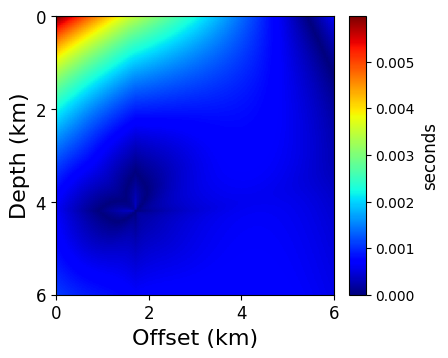

In [16]:
# Plot the computed tau

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fsm - T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Offset (km)', fontsize=16)
plt.xticks(fontsize=12)

plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=12)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("./figs/vofxz_surrogate/fsmerror.pdf", format='pdf', bbox_inches="tight")

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

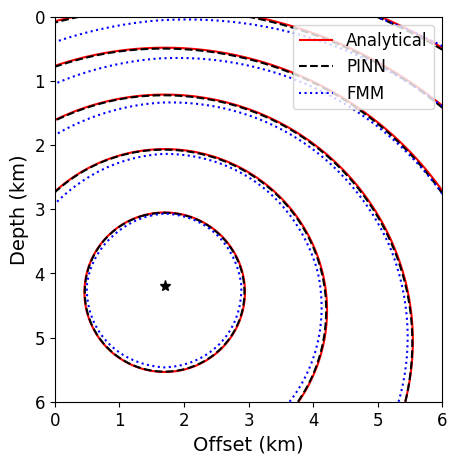

In [17]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(T_pred, 6, extent=[xmin,xmax,zmin,zmax], colors='k',linestyles = 'dashed')
im3 = ax.contour(T_fsm, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', "FMM"],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.savefig("./figs/vofxz_surrogate/contours.pdf", format='pdf', bbox_inches="tight")